# Capstone Project : Naive Bayes

In this notebook, we build a Naive Bayes classifier to predict the likelihood of churn given customer demographics, customer account information and customer services.

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from imblearn.pipeline import Pipeline as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings('ignore')

# global set
pd.set_option('display.max_columns', None)

In [3]:
#Define the plot Function
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)

# Preprocessing the Data
We have acquired and cleaned the data in this IPython Notebook. All the features were used for this analysis. Let's get the data prepared for modeling.

In [4]:
# global set
pd.set_option('display.max_columns', None)

# Load the data
telco = pd.read_csv("telco_eda.csv") 

# recode the features
# tranform to dummy variable
binvar = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn']
for col in binvar:
    telco[col] = telco[col].apply(lambda x: 1 if x=='Yes' else 0 )
    
transformed_telco = pd.get_dummies(telco)
transformed_telco.shape

# Train/test split
X = transformed_telco.drop(["Churn"], axis=1).values
y = transformed_telco.Churn.astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify = y)

# Gaussian NB - Random Under Sampling, Scaling 

In [8]:
%%time

# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", GaussianNB())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__var_smoothing =  [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 
                                    1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15])


# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
GNBrus   = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 3,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
GNBrus.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.8s


CPU times: user 355 ms, sys: 139 ms, total: 493 ms
Wall time: 19.7 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   19.6s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rus',
                                        RandomUnderSampler(random_state=30,
                                                           replacement=False,
                                                           sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'model__var_smoothing': [0.01, 0.001,

In [10]:
GNBrus.best_params_

{'model__var_smoothing': 0.01}

#####################
Test data
#####################
F1:  0.5732484076433121
Cohen Kappa:  0.34274143345620944
Brier:  0.3333333333333333
LogLoss:  3.515256766423132
              precision    recall  f1-score   support

           0       0.91      0.60      0.73      1033
           1       0.43      0.84      0.57       374

    accuracy                           0.67      1407
   macro avg       0.67      0.72      0.65      1407
weighted avg       0.79      0.67      0.69      1407



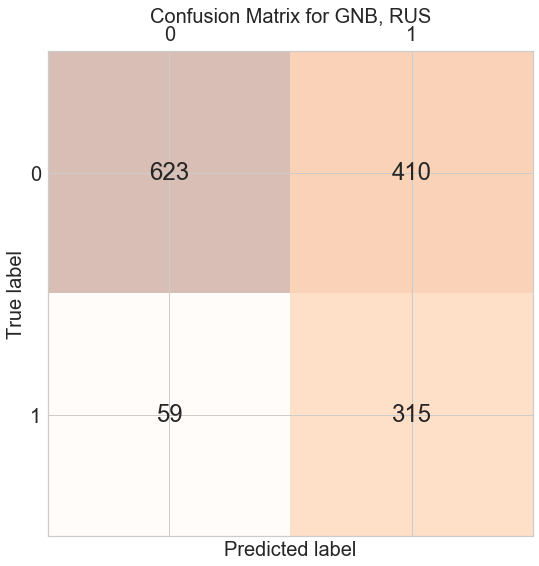

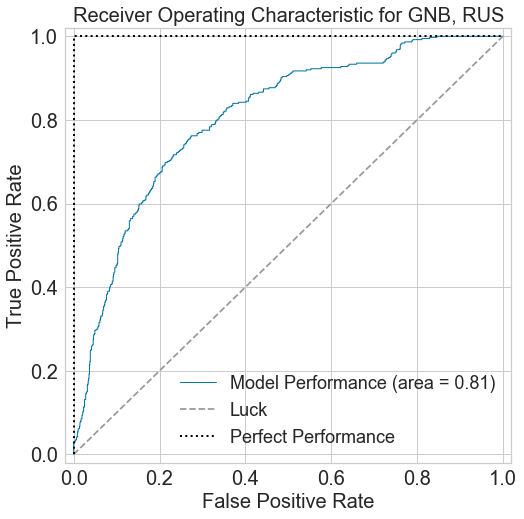

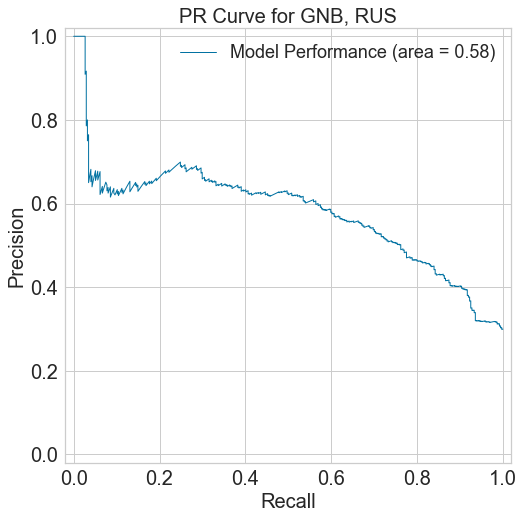

In [12]:
result(GNBrus, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="GNB, RUS")

# Gaussian NB - Scaling, Using Class Weight

In [14]:
%%time
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model",  GaussianNB())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__var_smoothing =  [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 
                                           1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
GNBcw = GridSearchCV(pipe, 
                    param_grid = param_grid, 
                    verbose = 3,
                    cv = cv,
                    n_jobs=-1,
                    scoring='average_precision',
                    iid=False)

# Training using CV
GNBcw.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.8s


CPU times: user 291 ms, sys: 42.7 ms, total: 334 ms
Wall time: 1.49 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.4s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'model__var_smoothing': [0.01, 0.001, 0.0001, 1e-05,
                                                  1e-06, 1e-07, 1e-08, 1e-09,
                                                  1e-10, 1e-11, 1e-12, 1e-13,
                                                  1e-14, 1e-15]},
             pre_dispatch='2*n_jobs', refit=True, 

In [15]:
GNBcw.best_params_

{'model__var_smoothing': 0.01}

#####################
Test data
#####################
F1:  0.5836431226765799
Cohen Kappa:  0.36254748006747317
Brier:  0.31840796019900497
LogLoss:  3.232662723066327
              precision    recall  f1-score   support

           0       0.91      0.62      0.74      1033
           1       0.45      0.84      0.58       374

    accuracy                           0.68      1407
   macro avg       0.68      0.73      0.66      1407
weighted avg       0.79      0.68      0.70      1407



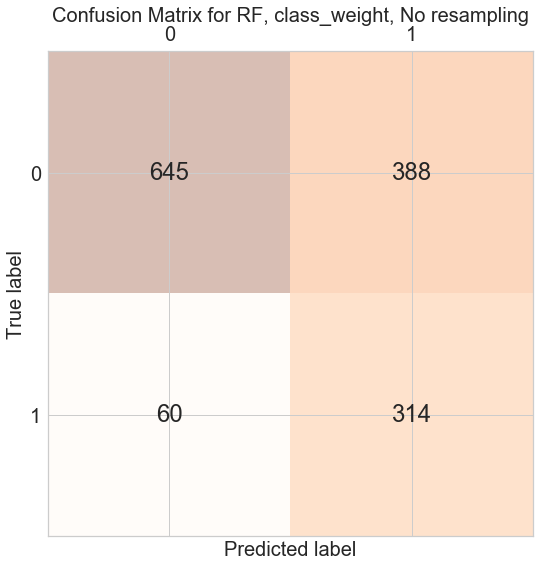

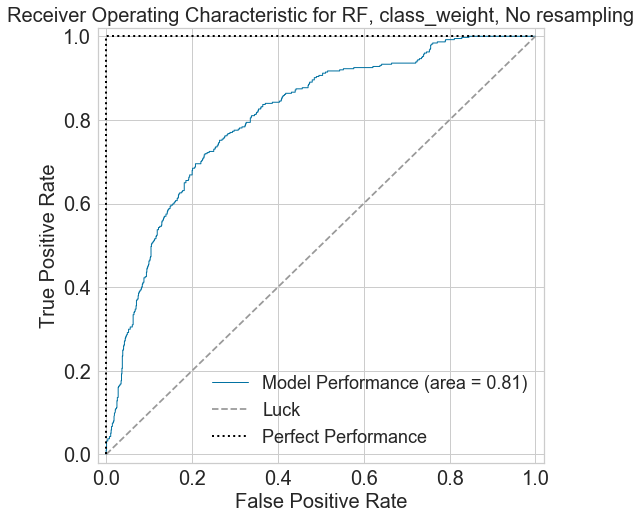

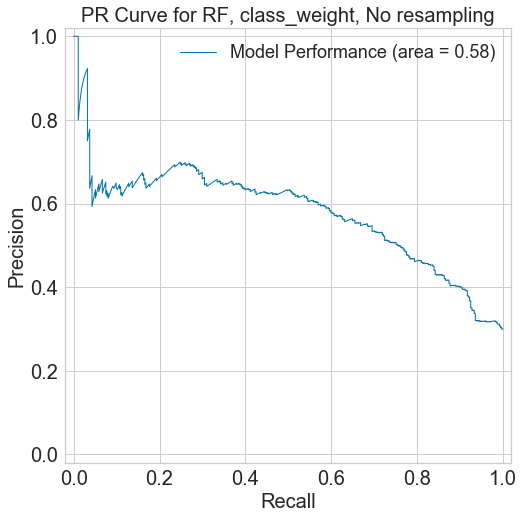

In [16]:
result(GNBcw, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="RF, class_weight, No resampling")

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.3s finished


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished


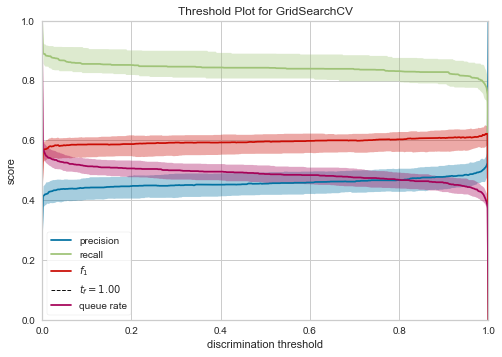

In [17]:
visualizer = DiscriminationThreshold(GNBcw)
visualizer.fit(X_train,y_train)
visualizer.poof()

# Gaussian NB  - Over Sampling, Scaling 

In [20]:
%%time
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("scaler",MinMaxScaler(feature_range=(0,1))),
         ("model", GaussianNB())]
pipe = pl(steps)

# Parameters
param_grid = dict(model__var_smoothing =  [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 
                                           1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
GNBsmote = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 4,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
GNBsmote.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s


CPU times: user 327 ms, sys: 39.3 ms, total: 366 ms
Wall time: 1.85 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.8s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=30,
                                              sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        GaussianNB(priors=None,
                                                   var_smoothing=1e-09))],
                                verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'model__var_smoothing': [0.01, 0.001, 0.0001, 1e-05,
            

In [21]:
GNBsmote.best_params_

{'model__var_smoothing': 0.01}

#####################
Test data
#####################
F1:  0.5854579792256847
Cohen Kappa:  0.3681954271183563
Brier:  0.31201137171286425
LogLoss:  3.6366057607058373
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1033
           1       0.45      0.83      0.59       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.79      0.69      0.71      1407



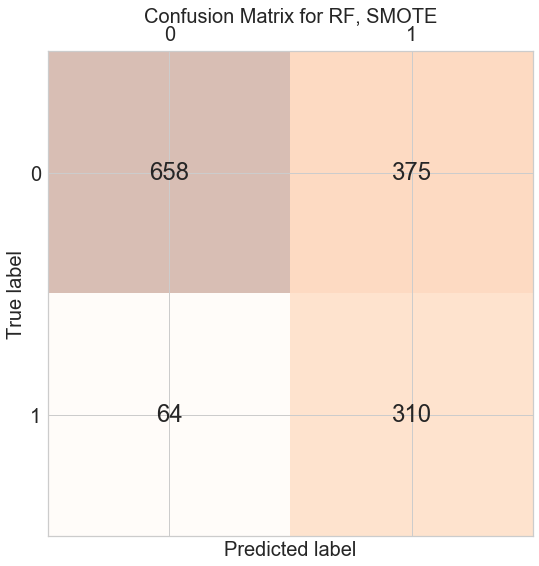

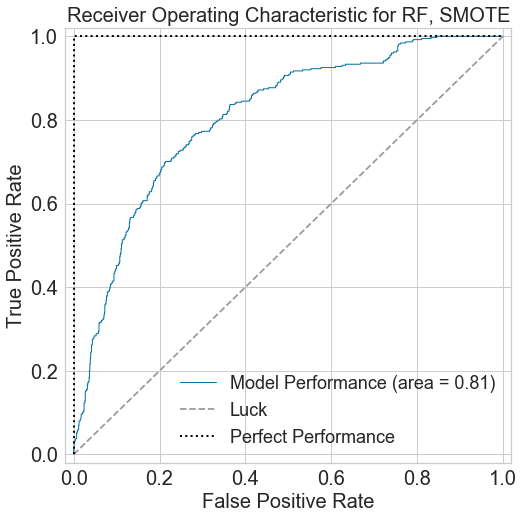

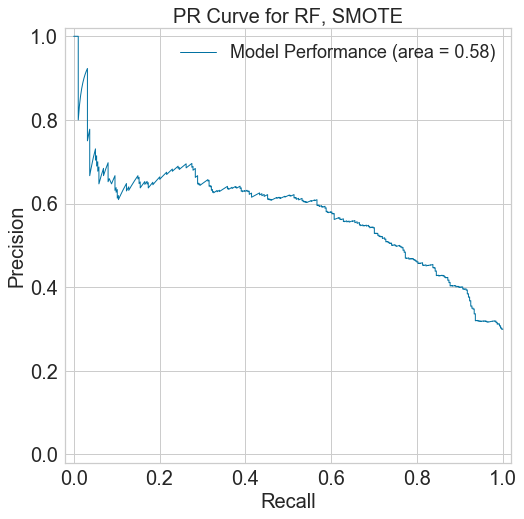

In [22]:
result(GNBsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="RF, SMOTE")